# Plot Sample Locations

Goal here is to create a simple plot showing sample locations

## Import packages

In [3]:
# general
import numpy as np
import pandas as pd

# plotting
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.patches as patches

# math
from shapely.geometry import Point, box


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## Setup

In [4]:
# Set filepaths

path_to_data = '../../data/'
path_to_samples = '../../data/sampling/master/'
path_to_angles = '../../data/angles/'
path_to_figures = '../../../figures/dip_adjusted_samples/'

## Load data

In [5]:
# load metadata
df = pd.read_excel(path_to_data + 'sampling/metadata.xlsx')

## Make the plots
Thanks Chat-GPT for the code below - enjoying the new o4 mini

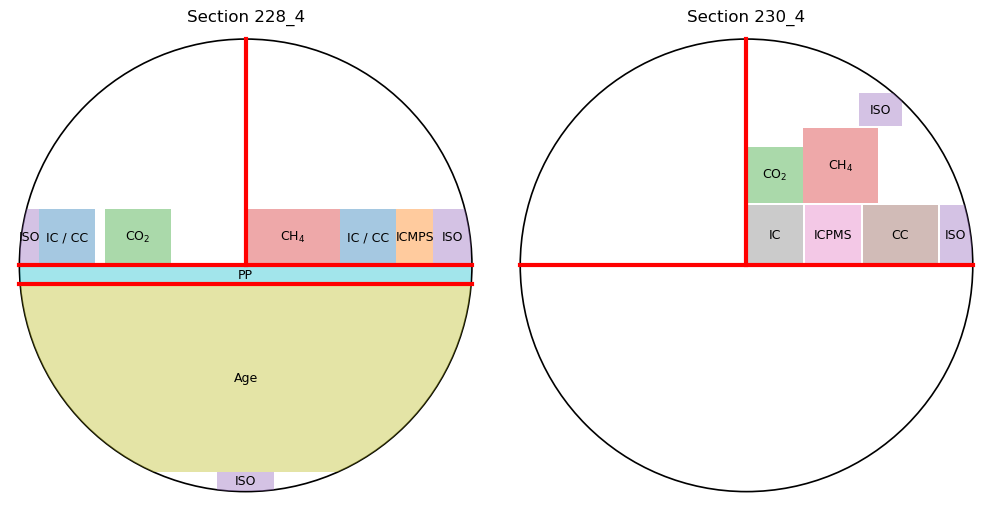

In [6]:
sections = df['section'].unique()
n = len(sections)
cols = min(3, n)
rows = int(np.ceil(n/cols))

fig, axs = plt.subplots(rows, cols,
                        figsize=(5*cols, 5*rows),
                        constrained_layout=True)
axs = axs.flatten()

# build a color map per meas_type
types = df['meas_type'].unique()
cmap = plt.get_cmap('tab10')
color_map = {t: cmap(i) for i, t in enumerate(types)}

radius = 241/2  # 120.5
center = (0, 0)

for ax, sec in zip(axs, sections):
    sub = df[df['section'] == sec]

    # 1) draw the circle at the origin
    circ = patches.Circle(center, radius,
                          edgecolor='black',
                          facecolor='none',
                          linewidth=1.2)
    ax.add_patch(circ)

    # 2) for each subsample, shift coords and clip to circle
    for _, row in sub.iterrows():
        x0 = row['x_lo']
        y0 = row['y_lo']
        w = row['x_hi'] - row['x_lo']
        h = row['y_hi'] - row['y_lo']

        rect = patches.Rectangle((x0, y0), w, h,
                                 facecolor=color_map[row['meas_type']],
                                 alpha=0.4,
                                 edgecolor='none')
        # clip rectangle to circle
        rect.set_clip_path(circ)
        ax.add_patch(rect)

        # label at rect center (still placed relative to full box)
        ax.text(x0 + w/2,
                y0 + h/2,
                row['meas_type'],
                ha='center',
                va='center',
                fontsize=9)

    ax.set_aspect('equal')
    ax.set_xlim(-radius-5, radius+5)
    ax.set_ylim(-radius-5, radius+5)
    ax.set_title(f'Section {sec}')
    #ax.grid()
    ax.axis('off')

# add ECM
for ax in axs:
    ax.plot([-120.5, 120.5], [0, 0], color='red', linewidth=3)
    ax.plot([0, 0], [0, 120.5], color='red', linewidth=3)
axs[0].plot([-120.5, 120.5], [-10, -10], color='red', linewidth=3)


# hide unused subplots
for ax in axs[n:]:
    ax.axis('off')

plt.show()

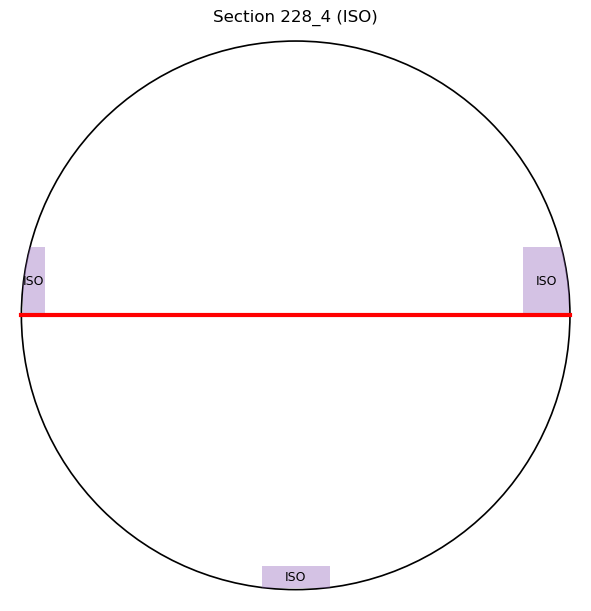

In [10]:
# second plot: only section '228_4' and meas_type 'ISO'
sub_iso = df[(df.section == '228_4') & (df.meas_type == 'ISO')]

fig2, ax2 = plt.subplots(1, 1, figsize=(6, 6), constrained_layout=True)

# circle
circ2 = patches.Circle(center, radius,
                       edgecolor='black',
                       facecolor='none',
                       linewidth=1.2)
ax2.add_patch(circ2)

# ISO rectangles only
for _, row in sub_iso.iterrows():
    x0, y0 = row.x_lo, row.y_lo
    w, h = row.x_hi - row.x_lo, row.y_hi - row.y_lo

    rect = patches.Rectangle((x0, y0), w, h,
                             facecolor=color_map[row.meas_type],
                             alpha=0.4, edgecolor='none')
    rect.set_clip_path(circ2)
    ax2.add_patch(rect)

    ax2.text(x0 + w/2, y0 + h/2, row.meas_type,
             ha='center', va='center', fontsize=9)

# ECM axes
ax2.plot([-radius, radius], [0, 0], color='red', linewidth=3)
#ax2.plot([0, 0], [0, radius], color='red', linewidth=3)

ax2.set_aspect('equal')
ax2.set_xlim(-radius - 5, radius + 5)
ax2.set_ylim(-radius - 5, radius + 5)
ax2.set_title('Section 228_4 (ISO)')
ax2.axis('off')

plt.show()

In [15]:
radius = 241/2  # 120.5
circle = Point(0, 0).buffer(radius, resolution=64)

def effective_center(row):
    # build the rectangle
    rect = box(row['x_lo'], row['y_lo'],
               row['x_hi'], row['y_hi'])
    # intersect with circle
    clipped = rect.intersection(circle)
    if clipped.is_empty:
        # no overlap → NaN; or you can choose to fallback to midpoint:
        return pd.Series({'x_center': np.nan,
                          'y_center': np.nan})
    # centroid of the clipped shape
    c = clipped.centroid
    return pd.Series({'x_center': c.x,
                      'y_center': c.y})

# apply across the DataFrame
df[['x_center', 'y_center']] = df.apply(effective_center, axis=1)